In [8]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
import tensorflow as tf

tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

In [31]:
# load the trained model

from sspcab.sspcab_tf import SSPCAB

MODEL_PATH = 'models/basic/mvtec-hazelnut/model.h5'
MODEL_HISTORY_PATH = 'models/basic/mvtec-hazelnut/history.json'

model = tf.keras.models.load_model(MODEL_PATH, custom_objects={'SSPCAB': SSPCAB})

### Display the learning curves of the model

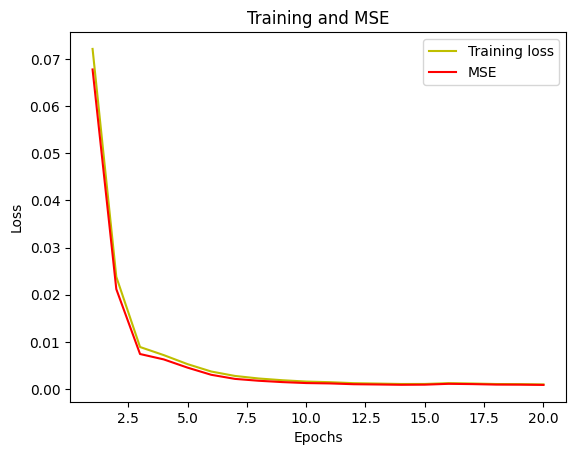

In [19]:
import json

history = json.load(open(MODEL_HISTORY_PATH, 'r'))

# plot the training history
loss = history['loss']
mse = history['mse']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, mse, 'r', label='MSE')
plt.title('Training and MSE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Testing the model

In [41]:
from keras.preprocessing.image import ImageDataGenerator

# load the test data
DATASET_PATH = 'datasets/mvtecad/hazelnut/'

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(128, 128),
    batch_size=32,
    class_mode='input',
    classes=['train']
)

validation_generator = datagen.flow_from_directory(
    DATASET_PATH + 'test/',
    target_size=(128, 128),
    batch_size=32,
    class_mode='input',
    classes=['good']
    )

anomaly_generator = datagen.flow_from_directory(
    DATASET_PATH + 'test/',
    target_size=(128, 128),
    batch_size=32,
    class_mode='input',
    classes=['defective']
    )

Found 391 images belonging to 1 classes.
Found 40 images belonging to 1 classes.
Found 70 images belonging to 1 classes.


In [42]:
# Get all batches generated by the datagen and pick a batch for prediction
#Just to test the model. 
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
while img_num <= validation_generator.batch_index:   #gets each generated batch of size batch_size
    data = validation_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1

predicted = model.predict(data_batch[0])  #Predict on

1/1 [==============================] - 1s 913ms/step


In [43]:
#Let us examine the reconstruction error between our validation data (good/normal images)
# and the anomaly images
validation_error = model.evaluate(validation_generator)
anomaly_error = model.evaluate(anomaly_generator)

print("Recon. error for the validation (normal) data is: ", validation_error)
print("Recon. error for the anomaly data is: ", anomaly_error)

3/3 [==============================] - 4s 1s/step - loss: 0.0019 - mse: 0.0018 - mae: 0.0227
Recon. error for the validation (normal) data is:  [0.0009476401028223336, 0.0008547563338652253, 0.021971220150589943]
Recon. error for the anomaly data is:  [0.0019394336268305779, 0.0018468062626197934, 0.022670922800898552]


In [44]:
# build the feature extractor (first 5 layers of the model)

feature_extractor = Sequential()

for layer in model.layers[:5]:
    feature_extractor.add(layer)
    


In [115]:
# Calculate KDE using sklearn
from sklearn.neighbors import KernelDensity

#Get encoded output of input images = Latent space
encoded_images = feature_extractor.predict(validation_generator)

# Flatten the encoder output because KDE from sklearn takes 1D vectors as input
encoder_output_shape = feature_extractor.output_shape #Here, we have 16x16x16
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]

encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]

#Fit KDE to the image latent data
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)

2/2 [==============================] - 1s 259ms/step


In [116]:
#Calculate density and reconstruction error to find their means values for
#good and anomaly images. 
#We use these mean and sigma to set thresholds. 
def calc_density_and_recon_error(batch_images):
    density_list=[]
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]-1):
        
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        encoded_img = feature_extractor.predict([[img]]) # Create a compressed version of the image using the encoder
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] # Flatten the compressed image
        density = kde.score_samples(encoded_img)[0] # get a density score for the new image
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
        density_list.append(density)
        recon_error_list.append(reconstruction_error)
        
    average_density = np.mean(np.array(density_list))  
    stdev_density = np.std(np.array(density_list)) 
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    
    return average_density, stdev_density, average_recon_error, stdev_recon_error



#Get average and std dev. of density and recon. error for uninfected and anomaly (parasited) images. 
#For this let us generate a batch of images for each. 
train_batch = validation_generator.next()[0]
anomaly_batch = anomaly_generator.next()[0]

normal_values = calc_density_and_recon_error(train_batch)
anomaly_values = calc_density_and_recon_error(anomaly_batch)

print("Normal values: ", normal_values)
print("Anomaly values: ", anomaly_values)

1/1 [==============================] - 0s 93ms/step - loss: 0.0015 - mse: 0.0014 - mae: 0.0298
Normal values:  (11309.452952807394, 5.534045113309962e-06, 0.0012009764416894364, 0.00019293467778773918)
Anomaly values:  (11276.53460609722, 24.1155089491489, 0.0022224342608223517, 0.001678143338906824)


In [120]:
density_threshold = 11300 # +- 9.18
reconstruction_error_threshold = 0.0021 # +- 0.00025

In [121]:
def check_anomaly(img_path):
    img  = Image.open(img_path)
    img = np.array(img.resize((128,128), Image.Resampling.LANCZOS))
    
    original_img = img.copy()
    
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    
    encoded_img = feature_extractor.predict([[img]]) 
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
    
    density = kde.score_samples(encoded_img)[0] 

    reconstruction = model.predict([[img]])
    
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[1]

    reconstruction_loss = np.abs(img - reconstruction)
    reconstruction_loss = np.mean(reconstruction_loss, axis=3)[0]
        
    return (density < density_threshold or reconstruction_error > reconstruction_error_threshold), original_img, reconstruction_loss

In [122]:
#Load a couple of test images and verify whether they are reported as anomalies.
import glob
defective_file_paths = glob.glob(f'{DATASET_PATH}/test/defective/**/*')
normal_file_paths = glob.glob(f'{DATASET_PATH}/test/good/*')

1/1 [==============================] - 0s 100ms/step - loss: 8.3742e-04 - mse: 7.4682e-04 - mae: 0.0218


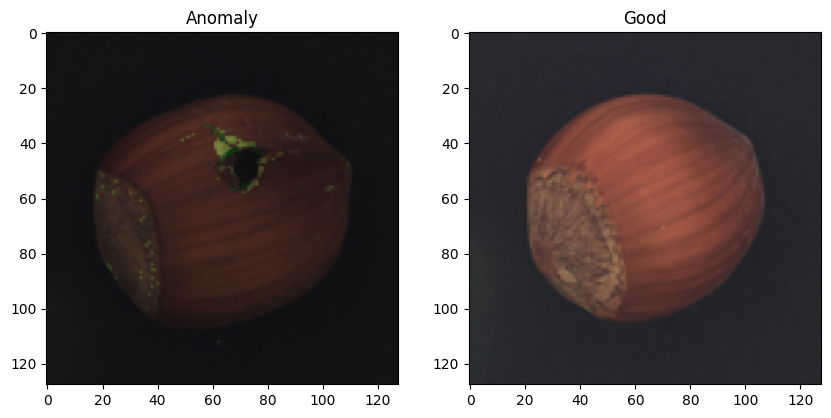

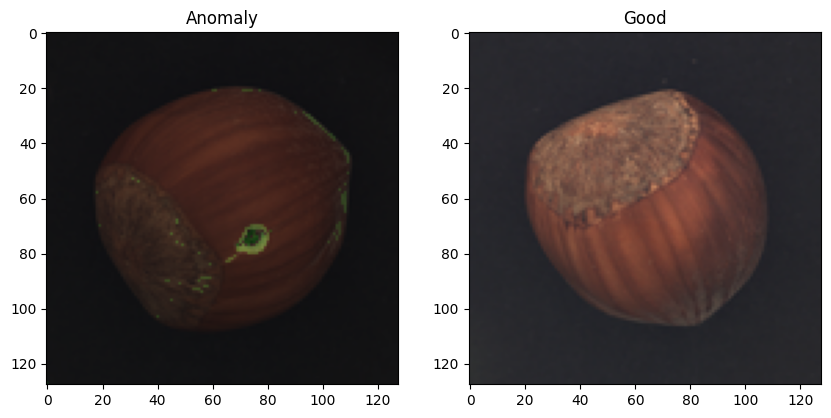

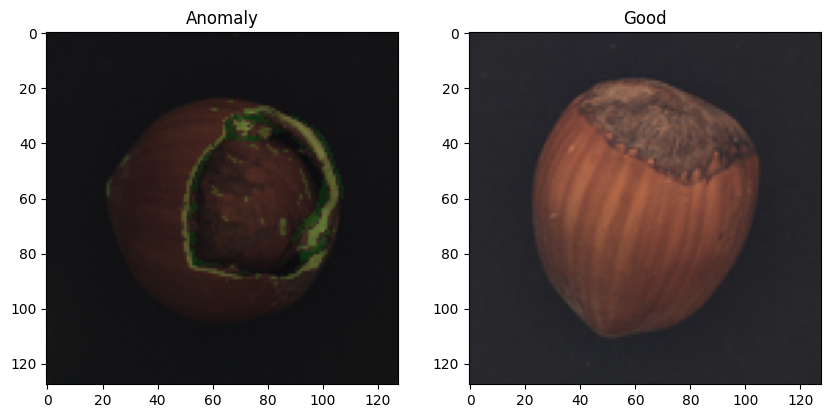

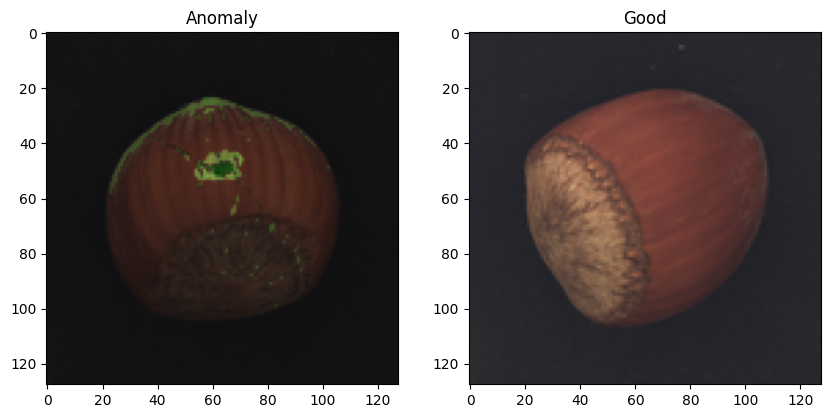

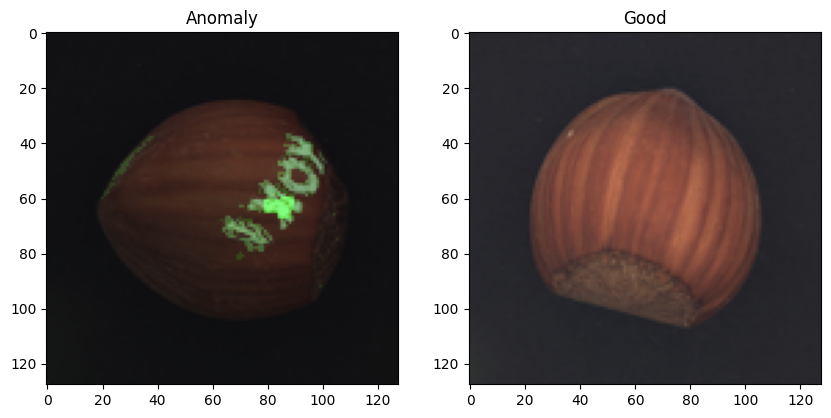

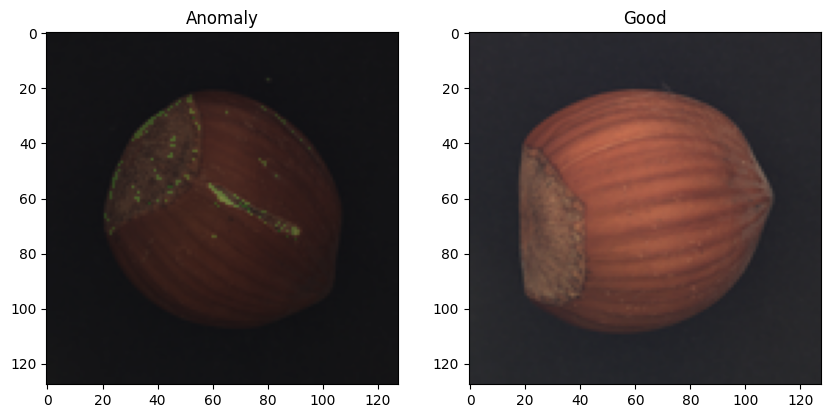

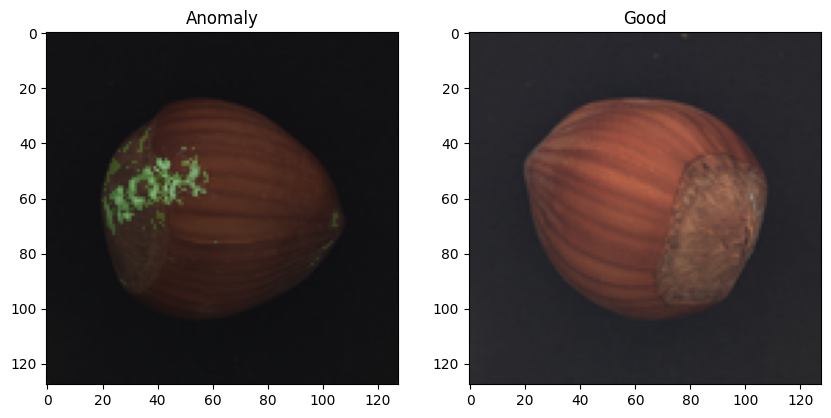

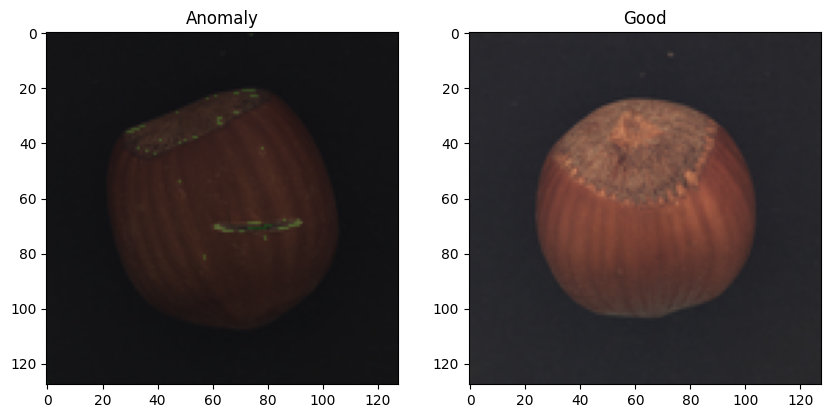

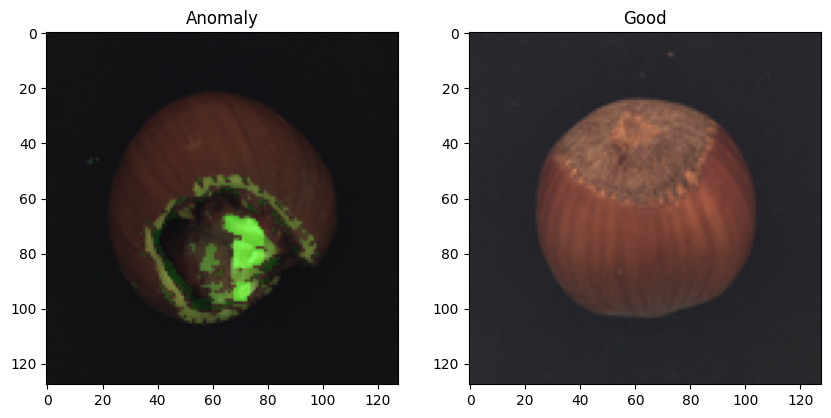

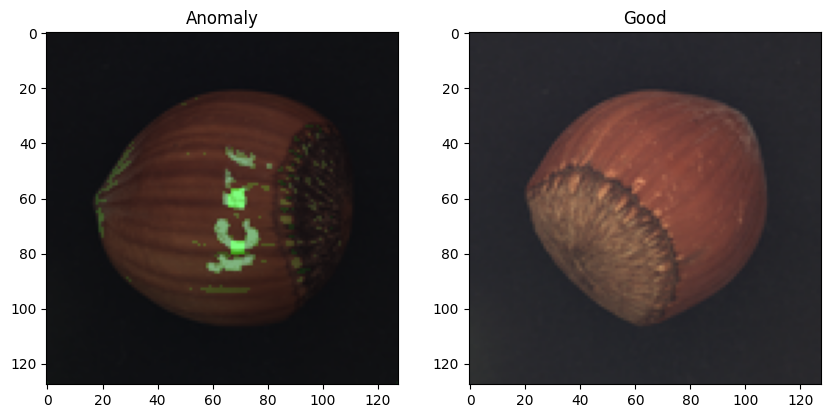

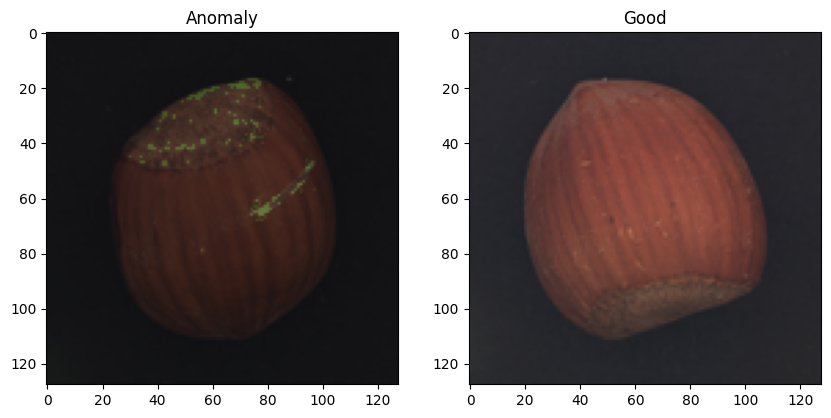

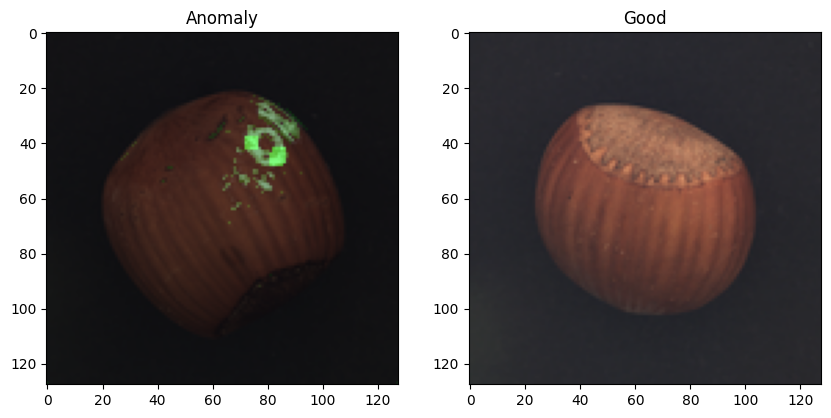

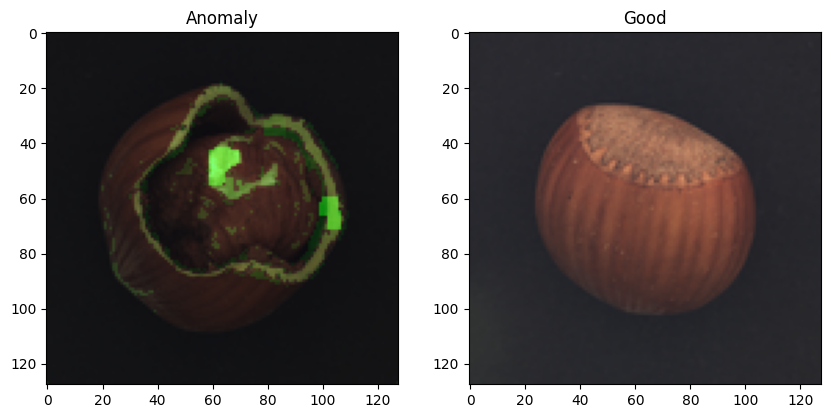

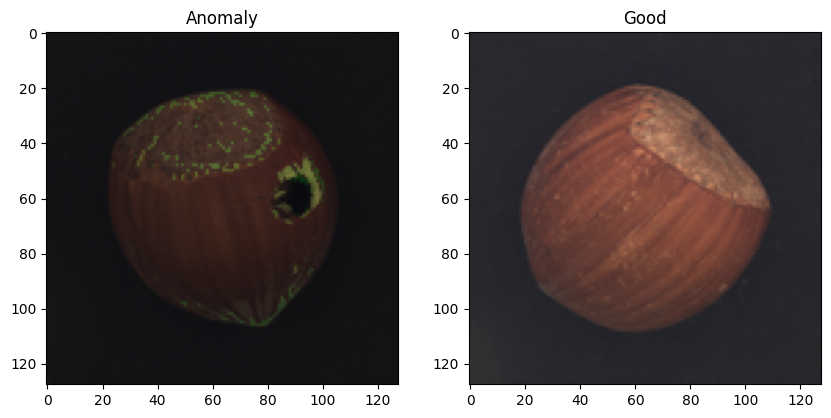

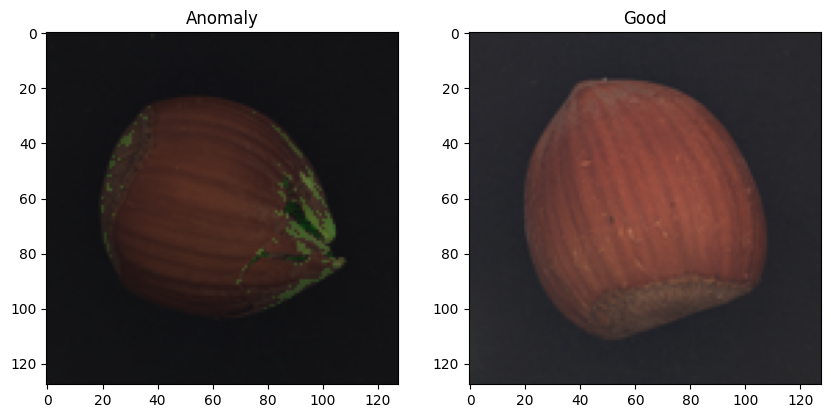

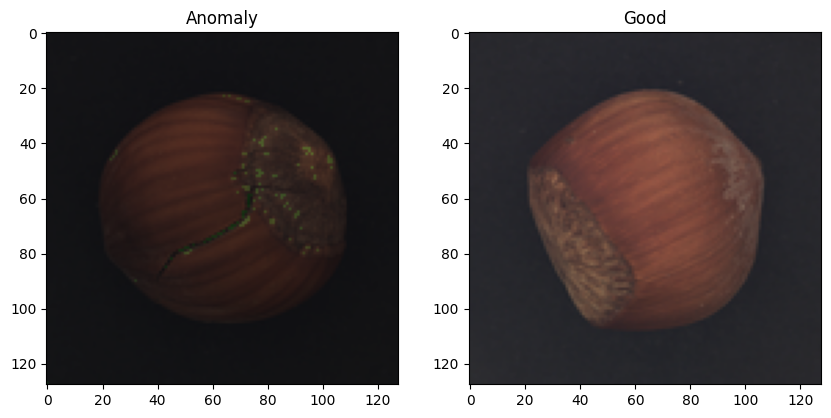

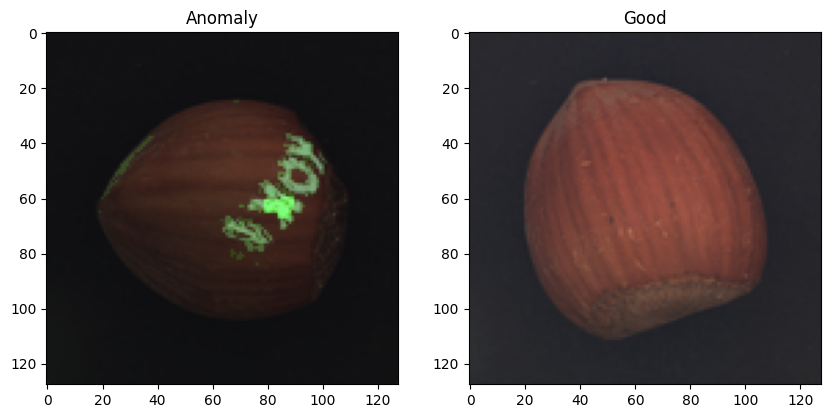

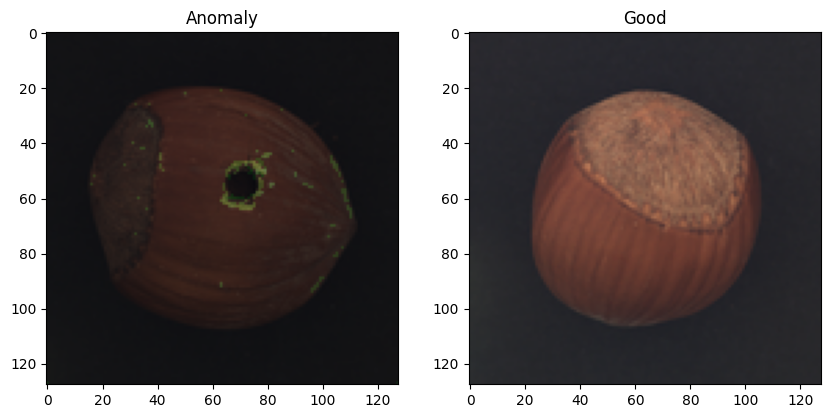

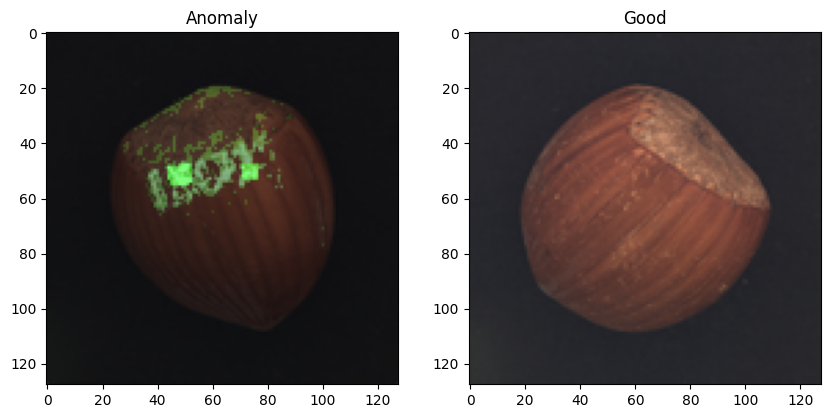

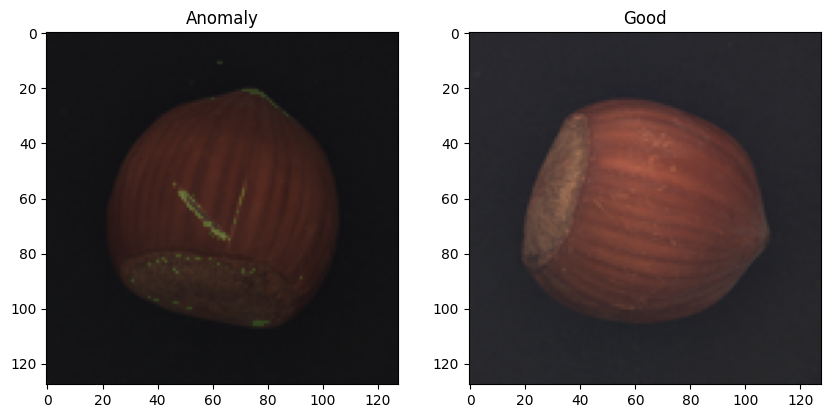

In [127]:
import cv2

for _ in range(20):
    defective_img = defective_file_paths[np.random.randint(0, len(defective_file_paths))]
    is_detected, img1, loss = check_anomaly(defective_img)

    normal_img = normal_file_paths[np.random.randint(0, len(normal_file_paths))]
    is_misclassified, img2, _ = check_anomaly(normal_img)

    fig, ax = plt.subplots(1,2, figsize=(10,10))

    ax[0].imshow(img1)
    ax[0].set_title("Anomaly" if is_detected else "Good")
    
    # add a mask of the reconstruction loss as a heatmap
    mask = loss > 0.08
    overlay = img1.copy()
    overlay[mask] = [0, 255, 0]
    
    
    new_overlay = cv2.morphologyEx(overlay, cv2.MORPH_OPEN, np.ones((5,5), np.uint8))

    # remove unaffected pixels
    new_overlay[~mask] = 0
    
    # only overlay the mask if the pixel is activated
            
    ax[0].imshow(new_overlay, alpha=0.5, cmap='binary', vmin=0, vmax=1)
    
        
    ax[1].imshow(img2)
    ax[1].set_title("Anomaly" if is_misclassified else "Good")

### AUROC and False Positive Rate

In [126]:
def roc_auc_score(y_true, y_pred):
    return np.mean(np.array(y_true) == np.array(y_pred))

y_true = []
y_pred = []

for img_path in defective_file_paths:
    is_detected, _, _ = check_anomaly(img_path)
    y_true.append(1)
    y_pred.append(int(is_detected))
    
for img_path in normal_file_paths:
    is_detected, _, _ = check_anomaly(img_path)
    y_true.append(0)
    y_pred.append(int(is_detected))
    
print("ROC AUC score: ", roc_auc_score(y_true, y_pred))
print('False positives: ', y_pred.count(1) - y_true.count(1))

1/1 [==============================] - 0s 97ms/step - loss: 0.0010 - mse: 9.1036e-04 - mae: 0.0227
ROC AUC score:  1.0
False positives:  0
